In [133]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import math

from deeplog              import DeepLog
from deeplog.preprocessor import Preprocessor
import torch
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import matplotlib.pyplot as plt

In [134]:
logs = pd.read_csv("linux.log_structured.csv")
labels = pd.read_csv("anomaly_label_linux.csv")

logs = logs.merge(labels, on="GroupId")

df = logs.rename(columns={
    "DateTime": "timestamp",
    "GroupId": "machine",
    "EventId": "event",
    "Label": "label",
})

mapping = {'Normal': 0, 'Anomaly': 1}
df['label'] = df['label'].map(mapping)

df = df[["timestamp", "machine", "event", "label"]]

df.to_csv("BSC_deeplog.csv", index=False)


In [135]:
df = pd.read_csv("BSC_deeplog.csv")

train_df = df[df["label"] == 0]
test_df  = df.copy()

train_df.drop(columns=["label"], inplace=True)
test_df.drop(columns=["label"], inplace=True)

train_df.to_csv("BSC_deeplog_train.csv", index=False)
test_df.to_csv("BSC_deeplog_test.csv",  index=False)


/tmp/ipykernel_10227/2111662430.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=["label"], inplace=True)


In [136]:
WINDOW  = 10          # długość kontekstu (h w paperze)
TIMEOUT = float('inf')  # nie obcinamy po czasie

pre = Preprocessor(length=WINDOW, timeout=TIMEOUT)

_, _, _, mapping_global = pre.csv("BSC_deeplog_test.csv")

In [137]:
df_train_full = pd.read_csv("BSC_deeplog_train.csv")   # same zdrowe rozruchy

boot_ids = df_train_full["machine"].unique()
train_ids, val_ids = train_test_split(
    boot_ids, test_size=0.2, random_state=42
)

train_df = df_train_full[df_train_full["machine"].isin(train_ids)]
val_df   = df_train_full[df_train_full["machine"].isin(val_ids)]

train_df.to_csv("BSC_deeplog_train.csv", index=False)
val_df.to_csv("BSC_deeplog_val.csv", index=False)


In [138]:


# === TRAIN ===
ctx_tr, ev_tr, labels_tr, mapping_tr = pre.csv("BSC_deeplog_train.csv", mapping=mapping_global)
# === TEST  ===
ctx_te, ev_te, labels_te, mapping_te = pre.csv("BSC_deeplog_test.csv", mapping=mapping_global)
# === VAL   ===
ctx_val, ev_val, labels_val, mapping_val = pre.csv("BSC_deeplog_val.csv", mapping=mapping_global)

n_events = len(mapping_tr)
print(n_events)

1035


In [139]:
print(len(mapping_global), len(mapping_te))

1035 1035


In [ ]:
train_ds = TensorDataset(ctx_tr, ev_tr)
val_ds   = TensorDataset(ctx_val, ev_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False)

In [141]:
deeplog = DeepLog(
    input_size  = n_events,
    hidden_size = 64,
    output_size = n_events,
).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deeplog.parameters(), lr=1e-3)

In [142]:
EPOCHS = 100
PATIENCE = 3
DELTA    = 1e-3

best_val_loss      = math.inf
epochs_no_improve  = 0
best_model_path    = "deeplog_bsc.pth"

train_losses = []
val_losses   = []

for epoch in range(EPOCHS):
    # --- TRAIN ---
    deeplog.train()
    running_train_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to('cuda')
        yb = yb.to('cuda')

        optimizer.zero_grad()
        logits = deeplog(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * xb.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- VALIDATION ---
    deeplog.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to('cuda')
            yb = yb.to('cuda')

            logits = deeplog(xb)
            loss = criterion(logits, yb)
            running_val_loss += loss.item() * xb.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(
        f"Epoch {epoch+1}/{EPOCHS} "
        f"- train_loss={epoch_train_loss:.4f} "
        f"- val_loss={epoch_val_loss:.4f}"
    )

    if epoch_val_loss < best_val_loss - DELTA:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0

        # zapisz najlepszy model
        torch.save(deeplog.state_dict(), best_model_path)
    else:
        epochs_no_improve += 1

        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break


Epoch 1/100 - train_loss=3.1360 - val_loss=2.2577
Epoch 2/100 - train_loss=2.0321 - val_loss=1.9127
Epoch 3/100 - train_loss=1.7886 - val_loss=1.7688
Epoch 4/100 - train_loss=1.6605 - val_loss=1.6988
Epoch 5/100 - train_loss=1.5797 - val_loss=1.6520
Epoch 6/100 - train_loss=1.5223 - val_loss=1.6235
Epoch 7/100 - train_loss=1.4768 - val_loss=1.6053
Epoch 8/100 - train_loss=1.4398 - val_loss=1.5964
Epoch 9/100 - train_loss=1.4079 - val_loss=1.5837
Epoch 10/100 - train_loss=1.3801 - val_loss=1.5722
Epoch 11/100 - train_loss=1.3546 - val_loss=1.5747
Epoch 12/100 - train_loss=1.3316 - val_loss=1.5743
Epoch 13/100 - train_loss=1.3111 - val_loss=1.5695
Epoch 14/100 - train_loss=1.2916 - val_loss=1.5764
Epoch 15/100 - train_loss=1.2743 - val_loss=1.5729
Epoch 16/100 - train_loss=1.2561 - val_loss=1.5771
Early stopping triggered.


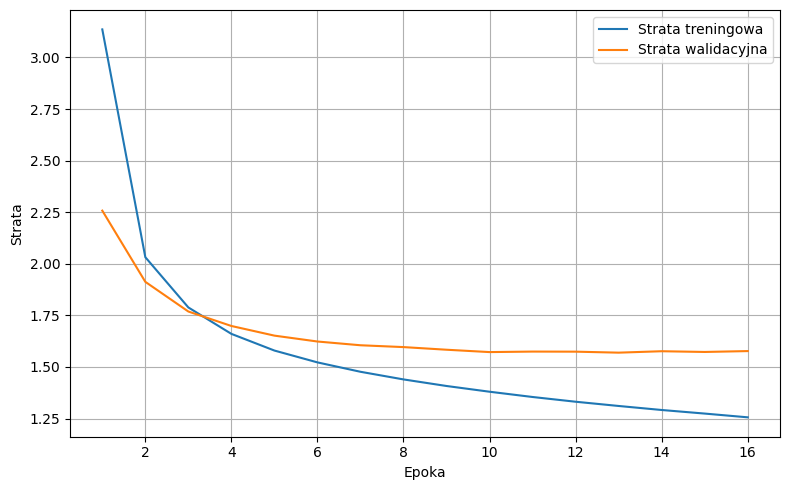

In [143]:
epochs = range(1, len(train_losses) + 1)
t_loss = train_losses
v_loss = val_losses

plt.figure(figsize=(8, 5))
plt.plot(epochs, t_loss, label="Strata treningowa")
plt.plot(epochs, v_loss, label="Strata walidacyjna")
plt.xlabel("Epoka")
plt.ylabel("Strata")
# plt.title("Przebieg uczenia DeepLog na zbiorze Linux")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Test

In [144]:
deeplog = DeepLog.load("deeplog_bsc.pth")

y_pred_test, conf = deeplog.predict(
    X = ctx_te,
    y = ev_te,
    k = 5,         # top-k
)

print("Top-1 report - predictions")

top1_te = (y_pred_test[:, 0] == ev_te)
top1_acc = top1_te.float().mean().item()

print(f"Top-1 accuracy (next-event prediction)")
print(f"{top1_acc:.4f}")
print("")

print("Top-k report - predictions")

topk_te = (y_pred_test == ev_te.unsqueeze(1)).any(dim=1)
topk_acc = topk_te.float().mean().item()

print(f"Top-{y_pred_test.shape[1]} accuracy (next-event prediction)")
print(f"{topk_acc:.4f}")
print("")

odict_keys(['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'out.weight', 'out.bias'])
[Epoch 1/1] average loss = 0.0000 ######################################## (100.00%) runtime 0:00:48.2
Top-1 report - predictions
Top-1 accuracy (next-event prediction)
0.6621

Top-k report - predictions
Top-5 accuracy (next-event prediction)
0.8421



In [146]:
is_anomaly_event   = ~topk_te
pred = is_anomaly_event.to(torch.int)

test_df = pd.read_csv("BSC_deeplog_test.csv")

ground_df = pd.read_csv("linux.log_structured.csv")

assert len(test_df) == len(is_anomaly_event)

test_df["is_anomaly_event"] = is_anomaly_event.cpu().numpy().astype(int)

templates = pd.read_csv("linux.log_templates.csv")  # EventId, EventTemplate, Occurrences

anomalies = test_df[test_df["is_anomaly_event"] == 1]

# ground_tmp = ground_df[["EventId", "Component"]].rename(columns={"EventId": "event"})

# top_events = (
#     anomalies.groupby("event")
#              .size()
#              .sort_values(ascending=False)
#              .head(20)
#              .reset_index(name="anomaly_count")
#     .merge(templates, left_on="event", right_on="EventId", how="left")
#     .merge(ground_tmp, on="event", how="left")
# )
# 1. policz anomalie per event
top_events = (
    anomalies.groupby("event")
             .size()
             .reset_index(name="anomaly_count")
             .sort_values("anomaly_count", ascending=False)
             .head(20)
)

# 2. unikalna mapa EventId -> Component z ground_df
component_map = (
    ground_df[["EventId", "Component"]]
    .drop_duplicates(subset=["EventId"])  # 1 wiersz na EventId
)

# 3. dołącz template po EventId
top_events = (
    top_events
    .merge(
        templates[["EventId", "EventTemplate", "Occurrences"]],
        left_on="event",
        right_on="EventId",
        how="left"
    )
    .merge(
        component_map,
        left_on="event",
        right_on="EventId",
        how="left"
    )
)

# 4. posprzątaj kolumny (EventId z mergy możemy wyrzucić)
top_events = top_events[["anomaly_count", "event", "EventTemplate", "Component"]]
top_events = top_events.rename(columns={"anomaly_count": "Anomaly Count", "event": "EventId"})

top_events


,Anomaly Count,EventId,EventTemplate,Component
0,1219,73897fbc,Started <*> - <*> <*> <*> service.,systemd[1]
1,1205,400247da,Started <*> - <*> <*>,systemd[1]
2,1201,55aefb10,[session uid<*> pid<*>] Successfully activated...,dbus-daemon[1065]
3,1164,a0ccd5ba,Supervising<*> threads of<*> processes of<*> u...,rtkit-daemon[1082]
4,1045,9cab2107,Starting <*> - <*> <*>,systemd[1]
5,1029,de230850,[system] Successfully activated service <*>,dbus-daemon[788]
6,986,84d822bd,Starting <*> - <*> <*> <*> service...,systemd[1]
7,958,7c80e50c,Reached target <*> - <*> <*> <*>,systemd[1]
8,865,f1f1f676,[session uid<*> pid<*>] Activating via systemd...,dbus-daemon[1065]
9,801,69e4ccda,Reached target <*> - <*> <*>,systemd[1]
